In [1]:
import numpy as np
import matplotlib
import os
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
from baselines.bench.monitor import load_results

In [2]:
X_TIMESTEPS = 'timesteps'
X_EPISODES = 'episodes'
X_WALLTIME = 'walltime(second)'
POSSIBLE_X_AXES = [X_TIMESTEPS, X_EPISODES, X_WALLTIME]
EPISODES_WINDOW = 2
COLORS = ['#f28e2b', '#4e79a7', 'seagreen', '#4e79a7', 'magenta', 'red', 'cyan', 'yellow', 'black', 'purple', 'pink',
        'brown', 'orange', 'coral', 'lightblue', 'lime', 'lavender', 'turquoise', 'teal',
        'darkgreen', 'tan', 'salmon', 'gold', 'lightpurple', 'darkred', 'darkblue']
LABELS = ['reward: with GP', 'reward: without GP', 'num.violations: with GP', 'num.violations: without GP']
#LABELS = ['reward: with GP', 'reward: without GP', 'num.catastrophes: with GP', 'num.catastrophes: without GP']
LINESTY = ['-', '--']
DASHES = [[], [9.5,3.5]]
MARKERS = ['.', '+']
# Set the font dictionaries (for plot title and axis titles)
title_font = {'size':'26', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'size':'23'}
legend_font = {'size':'11'}
ticklabel_font = {'labelsize':'20'}

In [3]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [4]:
def window_func(x, y, window, func):
    yw = rolling_window(y, window)
    yw_func = func(yw, axis=-1)
    return x[window-1:], yw_func

In [5]:
def ts2xy(ts, xaxis):
    if xaxis == X_TIMESTEPS:
        x = np.cumsum(ts.l.values)
        y = ts.r.values
    elif xaxis == X_EPISODES:
        x = np.arange(len(ts))
        y = ts.r.values
    elif xaxis == X_WALLTIME:
        x = ts.t.values
        y = ts.r.values
    else:
        raise NotImplementedError
    return x, y

In [6]:
def ts2xy_violation(ts, xaxis):
    if xaxis == X_TIMESTEPS:
        x = np.cumsum(ts.l.values)
        y = np.cumsum(ts.violation.values)
    elif xaxis == X_EPISODES:
        x = np.arange(len(ts))
        y = ts.c.values
    elif xaxis == X_WALLTIME:
        x = ts.t.values
        y = np.cumsum(ts.violation.values)
    else:
        raise NotImplementedError
    return x, y

In [7]:
def plot_curves(xy_list, xy_list_violations, xaxis, title, dirs):
    f, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    axs = [ax1, ax2]
    #f.set_size_inches(8, 4.2)
    f.set_size_inches(8, 8)
    maxx_reward = max(xy[0][-1] for xy in xy_list)
    maxx_violation = max(xy[0][-1] for xy in xy_list_violations)
#     maxy_cost = max(xy[1][-1] for xy in xy_list_cost)
#     print (maxy_cost)
    minx = 0
    for iAxes in range(2):
        ax = axs[iAxes]
        dashes = DASHES[iAxes]
        if iAxes == 0:
            xy = xy_list
            scatter_flag = True
            maxx = maxx_reward
            ylabel = "Average Episode Rewards"
        elif iAxes == 1:
            xy = xy_list_violations
            scatter_flag = False
            maxx = maxx_violation
            ylabel = "Cumulative Violations"
        for (i, (x, y)) in enumerate(xy):
            color = COLORS[i]
            label = LABELS[i+iAxes*2]
            linestyle = LINESTY[i]
            marker = MARKERS[i]
            if scatter_flag and False:
                ax.scatter(x, y, s=50, color=color, marker = marker)
            x, y_mean = window_func(x, y, EPISODES_WINDOW, np.mean) #So returns average of last EPISODE_WINDOW episodes
            ax.plot(x, y_mean, color=color, label=label, linestyle=linestyle, dashes = dashes)
#             else:
#                 ax.plot(x, y, color=color, label=label, linestyle=linestyle, dashes = dashes)
#         for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#             label.set_fontsize(15)
        if scatter_flag:
            ax.legend(bbox_to_anchor=(0,1.32,1,0.2), loc="upper left", prop=legend_font)
            #ax.legend(loc="best", prop=legend_font)
        else:
            ax.legend(bbox_to_anchor=(0,1.32,1,0.2), loc="upper right", prop=legend_font)
        ax.set_xlim(minx, maxx)
        ax.set_title(title, **title_font)
        ax.set_xlabel(xaxis, **axis_font)
        ax.set_ylabel(ylabel, **axis_font)
        ax.tick_params(axis='both', **ticklabel_font)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
    plt.tight_layout()
    plt.show()
    f.savefig(dirs[0] + "/cart-pole_timesteps.pdf", bbox_inches='tight')

In [8]:
def plot_results(dirs, num_timesteps, xaxis, task_name):
    tslist = []
    for i, dir in enumerate(dirs):
        ts = load_results(dir)
        if i == 1:
            num_timesteps = int(3e5)
        #ts = ts[np.logical_and(ts.l.cumsum() <= num_timesteps, ts.l.cumsum() >= 11000)]
        ts = ts[ts.l.cumsum() <= num_timesteps]
        tslist.append(ts)
    xy_list = [ts2xy(ts, xaxis) for ts in tslist]
    xy_list_violations = [ts2xy_violation(ts, xaxis) for ts in tslist]
    plot_curves(xy_list, xy_list_violations, xaxis, task_name, dirs)

/home/jiameng/packages/SafeDRL_GP/baselines/baselines/bench/monitor.py:161: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.headers = headers # HACK to preserve backwards compatibility
/home/jiameng/packages/SafeDRL_GP/baselines/baselines/bench/monitor.py:161: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.headers = headers # HACK to preserve backwards compatibility


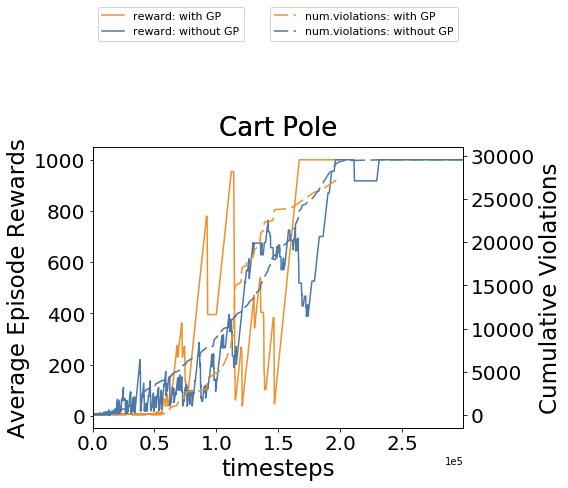

In [17]:
dirs = ['data_ddpg/cart-pole_0.1M_safe_ddpg', 'data_ddpg/cart-pole_1M_ddpg']
num_timesteps = 200000
xaxis = X_TIMESTEPS
task_name = "Cart Pole"
EPISODES_WINDOW = 20
plot_results(dirs, num_timesteps, xaxis, task_name)